In [9]:
import numpy as np
import numba as nb
from math import floor, atan2, pi, isnan, sqrt,copysign
import cv2
from matplotlib import pyplot as plt
import torch
from matplotlib.colors import LinearSegmentedColormap
from scipy.special import softmax
import os


In [4]:
def patch_process(img_gx, img_gy, h_hsize=5, step=1):
    H, W = img_gx.shape
    patch_num = len(range(h_hsize, H - h_hsize, step))*len(range(h_hsize, W - h_hsize, step))
    thetas = np.zeros((len(range(h_hsize, H - h_hsize, step)), len(range(h_hsize, W - h_hsize, step))))
    strs = np.zeros((len(range(h_hsize, H - h_hsize, step)), len(range(h_hsize, W - h_hsize, step))))
    cohers = np.zeros((len(range(h_hsize, H - h_hsize, step)), len(range(h_hsize, W - h_hsize, step))))
    ws_l2 = np.zeros((len(range(h_hsize, H - h_hsize, step)), len(range(h_hsize, W - h_hsize, step))))
    ws_ssim = np.zeros((len(range(h_hsize, H - h_hsize, step)), len(range(h_hsize, W - h_hsize, step))))
    ws_l1 = np.zeros((len(range(h_hsize, H - h_hsize, step)), len(range(h_hsize, W - h_hsize, step))))
    
    count = 0
    id1 = 0
    id2 = 0
    for i1 in range(h_hsize, H - h_hsize, step):
        
        for j1 in range(h_hsize, W - h_hsize, step):
            # pos = i1 % types_size * types_size + j1 % types_size
            # if pos in [0, 3, 5, 10, 12, 15]:
            #     continue
            idx1 = (slice(i1 - h_hsize, i1 + h_hsize + 1), slice(j1 - h_hsize, j1 + h_hsize + 1))
            patchX = img_gx[idx1]
            patchY = img_gy[idx1]
            theta, strength, coherence = grad_patch(patchX, patchY)
            thetas[id1, id2] = theta
            strs[id1, id2] = strength
            cohers[id1, id2] = coherence
            weights = softmax((np.array([strength, coherence, 0.2])/1))
            ws_l2[id1, id2] = weights[0]
            ws_ssim[id1, id2] = weights[1]
            ws_l1[id1, id2] = weights[2]
            id2+=1
            id2 = id2 % len(range(h_hsize, W - h_hsize, step))
            # if strength > 0.01 or coherence > 0.055:
            #     continue
    #assert count == patch_num
        id1+=1
    return thetas, strs, cohers, ws_l2, ws_ssim, ws_l1


def patch_process_bin(img_gx, img_gy, h_hsize=5, step=1):
    H, W = img_gx.shape
    patch_num = len(range(h_hsize, H - h_hsize, step))*len(range(h_hsize, W - h_hsize, step))
    thetas = np.zeros((len(range(h_hsize, H - h_hsize, step)), len(range(h_hsize, W - h_hsize, step))))
    strs = np.zeros((len(range(h_hsize, H - h_hsize, step)), len(range(h_hsize, W - h_hsize, step))))
    cohers = np.zeros((len(range(h_hsize, H - h_hsize, step)), len(range(h_hsize, W - h_hsize, step))))
    mask_l2 = np.zeros((len(range(h_hsize, H - h_hsize, step)), len(range(h_hsize, W - h_hsize, step))))
    mask_ssim = np.zeros((len(range(h_hsize, H - h_hsize, step)), len(range(h_hsize, W - h_hsize, step))))
    mask_l1 = np.zeros((len(range(h_hsize, H - h_hsize, step)), len(range(h_hsize, W - h_hsize, step))))
    mask_combined = np.zeros((len(range(h_hsize, H - h_hsize, step)), len(range(h_hsize, W - h_hsize, step))))
    
    count = 0
    id1 = 0
    id2 = 0
    for i1 in range(h_hsize, H - h_hsize, step):
        
        for j1 in range(h_hsize, W - h_hsize, step):
            # pos = i1 % types_size * types_size + j1 % types_size
            # if pos in [0, 3, 5, 10, 12, 15]:
            #     continue
            idx1 = (slice(i1 - h_hsize, i1 + h_hsize + 1), slice(j1 - h_hsize, j1 + h_hsize + 1))
            patchX = img_gx[idx1]
            patchY = img_gy[idx1]
            theta, strength, coherence = grad_patch(patchX, patchY)
            thetas[id1, id2] = theta
            strs[id1, id2] = strength
            cohers[id1, id2] = coherence
            if strength > 0.65:
                mask_l2[id1,id2] = 1
                mask_combined[id1, id2] = 0
            else:
                if coherence>0.15:
                    mask_ssim[id1,id2] = 1
                    mask_combined[id1, id2] = 1
                else:
                    mask_l1[id1,id2] = 1
                    mask_combined[id1, id2] = 2
            id2+=1
            id2 = id2 % len(range(h_hsize, W - h_hsize, step))
            # if strength > 0.01 or coherence > 0.055:
            #     continue
    #assert count == patch_num
        id1+=1
    return thetas, strs, cohers, mask_l2, mask_ssim, mask_l1, mask_combined



def grad_patch(patch_x, patch_y):
    gx = patch_x.ravel()
    gy = patch_y.ravel()
    G = np.vstack((gx, gy)).T
    x = np.dot(G.T, G)
    w, v = np.linalg.eig(x)
    index = w.argsort()[::-1]
    w = w[index]
    v = v[:, index]
    theta = atan2(v[1, 0], v[0, 0])
    if theta < 0:
        theta = theta + pi
    theta = theta/pi
    lamda = copysign(1,w[0])*sqrt(abs(w[0]))
    u = (sqrt(abs(w[0])) -sqrt(abs(w[1]))) / ((sqrt(abs(w[0]))) + sqrt(abs(w[1])) + 0.00000000000000001)
    #u = (copysign(1,w[0])*sqrt(abs(w[0])) - copysign(1,w[1])*sqrt(abs(w[1]))) / ((copysign(1,w[0])*sqrt(abs(w[0]))) + copysign(1,w[1])*sqrt(abs(w[1])) + 0.00000000000000001)
    return theta, lamda, u



In [5]:
from scipy.ndimage import gaussian_filter

import numpy as np
import imageio
import torch
import torch.utils.data as data

In [6]:
def rgb2yuv(rgb):
    out = np.zeros_like(rgb)
    out[:, :, 0] = 0.299 * rgb[:, :, 0] + 0.587 * rgb[:, :, 1] + 0.114 * rgb[:, :, 2]
    out[:, :, 1] = -0.1687 * rgb[:, :, 0] - 0.3313 * rgb[:, :, 1] + 0.5 * rgb[:, :, 2] + 0.5
    out[:, :, 2] = 0.5 * rgb[:, :, 0] - 0.4187 * rgb[:, :, 1] - 0.0813 * rgb[:, :, 2] + 0.5
    return out

In [40]:
img_folder = './X4/'
img_path = "img002x4.png"

In [41]:
_img = imageio.imread(os.path.join(img_folder,img_path))
lr = rgb2yuv((_img.astype('float') / 255.))[:,:,0]
lr = gaussian_filter(lr, sigma=0.8)
gx,gy = np.gradient(lr)

In [42]:
h_hsize = 3
thetas, strs, cohers, mask_l2, mask_ssim, mask_l1, mask_combined = patch_process_bin(gx, gy,h_hsize = h_hsize)

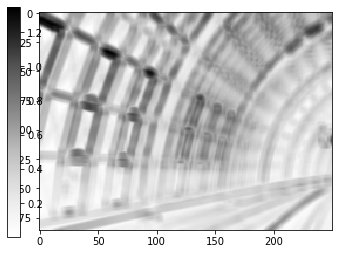

In [43]:
fig = plt.figure()
ax = fig.add_subplot(111)
axp = ax.imshow(strs,cmap='Greys')
# Adding the colorbar
cbaxes = fig.add_axes([0.1, 0.1, 0.03, 0.8])  # This is the position for the colorbar
cb = plt.colorbar(axp, cax = cbaxes)
plt.imsave(img_path+'_patchsize'+str(h_hsize)+'_strength.png',strs,cmap='Greys')
plt.show()

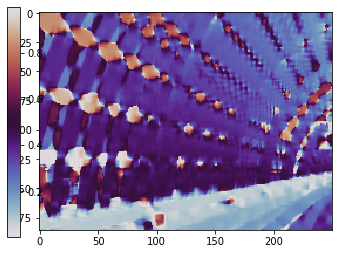

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111)
axp = ax.imshow(thetas, cmap='twilight')
# Adding the colorbar
cbaxes = fig.add_axes([0.1, 0.1, 0.03, 0.8])  # This is the position for the colorbar
cb = plt.colorbar(axp, cax = cbaxes)
plt.imsave(img_path+'_patchsize'+str(h_hsize)+'_theta.png',thetas, cmap='twilight')
plt.show()

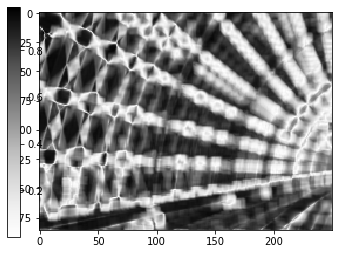

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111)
axp = ax.imshow(cohers,cmap='Greys')
# Adding the colorbar
cbaxes = fig.add_axes([0.1, 0.1, 0.03, 0.8])  # This is the position for the colorbar
cb = plt.colorbar(axp, cax = cbaxes)
plt.imsave(img_path+'_patchsize'+str(h_hsize)+'_coherence.png',cohers,cmap='Greys')
plt.show()